In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your data (replace 'your_file.csv' with your CSV path)
df = pd.read_csv('/Users/danielbrown/Desktop/MTA_Bus_Route_Segment_Speeds__Beginning_2025_20250910.csv', parse_dates=['Timestamp'])

# Quick look at the data
print(df.head())
print(df.info())
# Unique values
unique_next_stops = df["Next Timepoint Stop Name"].unique()
print(unique_next_stops)

# How many unique
print("Number of unique stops:", df["Next Timepoint Stop Name"].nunique())

# Frequency counts
stop_counts = df["Next Timepoint Stop Name"].value_counts()
print(stop_counts.head(20))  # top 20 stops


   Year  Month           Timestamp Day of Week  Hour of Day Route ID  \
0  2025      3 2025-03-01 21:00:00    Thursday           21    BX12+   
1  2025      3 2025-03-01 17:00:00    Thursday           17    BX12+   
2  2025      3 2025-03-01 08:00:00    Thursday            8    BX12+   
3  2025      3 2025-03-01 15:00:00    Thursday           15    BX12+   
4  2025      3 2025-03-01 06:00:00    Thursday            6    BX12+   

  Direction Borough Route Type  Stop Order  ...  Next Timepoint Stop ID  \
0         W   Bronx        SBS           1  ...                  103255   
1         W   Bronx        SBS           1  ...                  103255   
2         W   Bronx        SBS           1  ...                  103255   
3         W   Bronx        SBS           1  ...                  103255   
4         W   Bronx        SBS           1  ...                  103255   

  Next Timepoint Stop Name  Next Timepoint Stop Latitude  \
0       EDSON AV/BARTOW AV                     40.868062

/var/folders/r2/62xph3kj5rj_w51slp5lpvyc0000gn/T/ipykernel_13219/2387867871.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/Users/danielbrown/Desktop/MTA_Bus_Route_Segment_Speeds__Beginning_2025_20250910.csv', parse_dates=['Timestamp'])


In [2]:
import pandas as pd

# Paths to your GTFS files
trips_path = "/Users/danielbrown/Desktop/gtfs_bx-3/trips.txt"
shapes_path = "/Users/danielbrown/Desktop/gtfs_bx-3/shapes.txt"

# Load GTFS files
trips = pd.read_csv(trips_path)
shapes = pd.read_csv(shapes_path)

print("Trips columns:", trips.columns)
print("Shapes columns:", shapes.columns)

print("Unique shape_ids in trips:", trips['shape_id'].nunique())
print("Unique shape_ids in shapes:", shapes['shape_id'].nunique())
print(shapes)

Trips columns: Index(['route_id', 'service_id', 'trip_id', 'trip_headsign', 'direction_id',
       'block_id', 'shape_id'],
      dtype='object')
Shapes columns: Index(['shape_id', 'shape_pt_lat', 'shape_pt_lon', 'shape_pt_sequence'], dtype='object')
Unique shape_ids in trips: 236
Unique shape_ids in shapes: 236
        shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence
0       BX010102     40.880624    -73.886010              10001
1       BX010102     40.880472    -73.885939              10002
2       BX010102     40.879792    -73.885819              10003
3       BX010102     40.879522    -73.885799              10004
4       BX010102     40.879316    -73.885768              10005
...          ...           ...           ...                ...
48992  SBS410102     40.861452    -73.891609              70021
48993  SBS410102     40.861712    -73.891349              70022
48994  SBS410102     40.861872    -73.891139              70023
48995  SBS410102     40.862192    -73.890699  

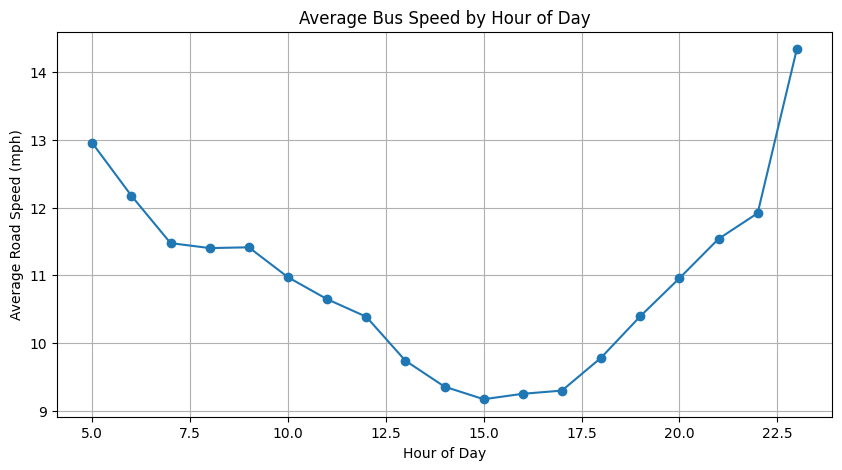

In [3]:
# Group by Hour of Day and compute mean speed
hourly_speed = df.groupby('Hour of Day')['Average Road Speed'].mean()

plt.figure(figsize=(10,5))
plt.plot(hourly_speed.index, hourly_speed.values, marker='o')
plt.title('Average Bus Speed by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Road Speed (mph)')
plt.grid(True)
plt.show()


In [4]:
import pandas as pd
import json

# Assuming your dataframe is named df

# 1. Group by Stop Pair + Hour (you can also include Day of Week if needed)
agg = (
    df.groupby([
        "Timepoint Stop ID", "Next Timepoint Stop ID", "Hour of Day"
    ])
    .agg({
        "Timepoint Stop Latitude": "first",
        "Timepoint Stop Longitude": "first",
        "Next Timepoint Stop Latitude": "first",
        "Next Timepoint Stop Longitude": "first",
        "Average Road Speed": "mean",
        "Bus Trip Count": "sum"
    })
    .reset_index()
)

# 2. Build GeoJSON
features = []
for _, row in agg.iterrows():
    feature = {
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": [
                [row["Timepoint Stop Longitude"], row["Timepoint Stop Latitude"]],
                [row["Next Timepoint Stop Longitude"], row["Next Timepoint Stop Latitude"]],
            ],
        },
        "properties": {
            "from_stop_id": int(row["Timepoint Stop ID"]),
            "to_stop_id": int(row["Next Timepoint Stop ID"]),
            "hour": int(row["Hour of Day"]),
            "avg_speed": float(row["Average Road Speed"]),
            "trip_count": int(row["Bus Trip Count"]),
        },
    }
    features.append(feature)

geojson = {"type": "FeatureCollection", "features": features}

# 3. Save to file
with open("/Users/danielbrown/Desktop/bx12_segments.geojson", "w") as f:
    json.dump(geojson, f)

#/Users/danielbrown/Desktop/Bus_Lanes_-_Local_Streets_20250910.csv

In [5]:
#print(geojson)

In [38]:
import pandas as pd
import json
from math import radians, sin, cos, sqrt, atan2

# --- 1. Load GTFS shapes ---
shapes = pd.read_csv("/Users/danielbrown/Desktop/gtfs_bx-3/shapes.txt")
shapes = shapes.sort_values(["shape_id", "shape_pt_sequence"])

# For now pick one shape_id (BX3 direction)
shape_id = "SBS120031"
route_shape = shapes[shapes["shape_id"] == shape_id]

# Convert to list of coords
shape_coords = list(zip(route_shape["shape_pt_lon"], route_shape["shape_pt_lat"]))

# --- 2. Helper: haversine distance ---
def haversine(lon1, lat1, lon2, lat2):
    R = 6371e3
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi, dlambda = radians(lat2-lat1), radians(lon2-lon1)
    a = sin(dphi/2)**2 + cos(phi1)*cos(phi2)*sin(dlambda/2)**2
    return 2*R*atan2(sqrt(a), sqrt(1-a))

def closest_index(lat, lon, coords):
    return min(range(len(coords)),
               key=lambda i: haversine(lon, lat, coords[i][1], coords[i][0]))

# --- 3. Merge with speed dataset ---
speeds = pd.read_csv("/Users/danielbrown/Desktop/MTA_Bus_Route_Segment_Speeds__Beginning_2025_20250910.csv", parse_dates=["Timestamp"])

features = []
for _, row in speeds.iterrows():
    # Find indices along shape for stop and next stop
    i1 = closest_index(row["Timepoint Stop Latitude"], row["Timepoint Stop Longitude"], shape_coords)
    i2 = closest_index(row["Next Timepoint Stop Latitude"], row["Next Timepoint Stop Longitude"], shape_coords)
    if i1 > i2: i1, i2 = i2, i1

    segment_coords = shape_coords[i1:i2+1]

    features.append({
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": segment_coords
        },
        "properties": {
            "route_id": row["Route ID"],
            "hour": row["Hour of Day"],
            "speed": row["Average Road Speed"],
            "trips": row["Bus Trip Count"]
        }
    })

geojson = {"type": "FeatureCollection", "features": features}

with open("/Users/danielbrown/Desktop/bx12_speeds_shapes.geojson", "w") as f:
    json.dump(geojson, f)


/var/folders/r2/62xph3kj5rj_w51slp5lpvyc0000gn/T/ipykernel_11997/3063603599.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  speeds = pd.read_csv("/Users/danielbrown/Desktop/MTA_Bus_Route_Segment_Speeds__Beginning_2025_20250910.csv", parse_dates=["Timestamp"])


In [6]:
#print(geojson)

In [7]:
import pandas as pd
import json
from math import radians, sin, cos, sqrt, atan2

# --- 1. Load GTFS shapes ---
shapes = pd.read_csv("/Users/danielbrown/Desktop/gtfs_bx-3/shapes.txt")
shapes = shapes.sort_values(["shape_id", "shape_pt_sequence"])

# For now pick one shape_id
shape_id = "SBS120031"
route_shape = shapes[shapes["shape_id"] == shape_id]

# Convert to list of coords (lon, lat)
shape_coords = list(zip(route_shape["shape_pt_lon"], route_shape["shape_pt_lat"]))

# --- 2. Helper: haversine distance ---
def haversine(lat1, lon1, lat2, lon2):
    R = 6371e3  # meters
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi, dlambda = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dphi/2)**2 + cos(phi1) * cos(phi2) * sin(dlambda/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1-a))

def closest_index(lat, lon, coords):
    # coords = list of (lon, lat)
    return min(range(len(coords)),
               key=lambda i: haversine(lat, lon, coords[i][1], coords[i][0]))

# --- 3. Load speed dataset ---
speeds = pd.read_csv("/Users/danielbrown/Desktop/MTA_Bus_Route_Segment_Speeds__Beginning_2025_20250910.csv",
                     parse_dates=["Timestamp"])

features = []
for _, row in speeds.iterrows():
    # Find indices along shape for stop and next stop
    i1 = closest_index(row["Timepoint Stop Latitude"], row["Timepoint Stop Longitude"], shape_coords)
    i2 = closest_index(row["Next Timepoint Stop Latitude"], row["Next Timepoint Stop Longitude"], shape_coords)
    
    # ensure i1 < i2
    if i1 > i2: i1, i2 = i2, i1
    
    # if indices are same, fallback to a direct line between stops
    if i1 == i2:
        segment_coords = [
            (row["Timepoint Stop Longitude"], row["Timepoint Stop Latitude"]),
            (row["Next Timepoint Stop Longitude"], row["Next Timepoint Stop Latitude"])
        ]
    else:
        segment_coords = shape_coords[i1:i2+1]

    features.append({
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": segment_coords
        },
        "properties": {
            "route_id": row["Route ID"],
            "hour": row["Hour of Day"],
            "speed": row["Average Road Speed"],
            "trips": row["Bus Trip Count"]
        }
    })

geojson = {"type": "FeatureCollection", "features": features}

with open("/Users/danielbrown/Desktop/bx12_speeds_shapes.geojson", "w") as f:
    json.dump(geojson, f)

print(f"GeoJSON created with {len(features)} features")


/var/folders/r2/62xph3kj5rj_w51slp5lpvyc0000gn/T/ipykernel_13219/2891219715.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  speeds = pd.read_csv("/Users/danielbrown/Desktop/MTA_Bus_Route_Segment_Speeds__Beginning_2025_20250910.csv",


GeoJSON created with 4360 features


In [8]:
#print(geojson)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [9]:
import pandas as pd
import json
from math import radians, sin, cos, sqrt, atan2

# --- 1. Load GTFS shapes and trips ---
shapes = pd.read_csv("/Users/danielbrown/Desktop/gtfs_bx-3/shapes.txt")
shapes = shapes.sort_values(["shape_id", "shape_pt_sequence"])

trips = pd.read_csv("/Users/danielbrown/Desktop/gtfs_bx-3/trips.txt")

# --- 2. Load speeds ---
speeds = pd.read_csv(
    "/Users/danielbrown/Desktop/MTA_Bus_Route_Segment_Speeds__Beginning_2025_20250910.csv",
    parse_dates=["Timestamp"]
)

# --- 3. Helper functions ---
def haversine(lat1, lon1, lat2, lon2):
    R = 6371e3
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi, dlambda = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dphi/2)**2 + cos(phi1)*cos(phi2)*sin(dlambda/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1-a))

def closest_index(lat, lon, coords):
    return min(range(len(coords)), key=lambda i: haversine(lat, lon, coords[i][1], coords[i][0]))

# --- 4. Map route+direction to shape_id ---
# Assume speeds Direction matches trips.direction_id somehow (or convert W/E to 0/1)
# We'll create a mapping: (route_id, direction) -> shape_id
direction_map = trips.groupby(['route_id', 'direction_id'])['shape_id'].first().to_dict()

# For your speeds data, convert Direction to 0/1 if needed
dir_map = {'W':0, 'E':1}  # adjust as needed
speeds['direction_id'] = speeds['Direction'].map(dir_map)

features = []

for _, row in speeds.iterrows():
    route_dir_key = (row["Route ID"], row["direction_id"])
    if route_dir_key not in direction_map:
        continue
    shape_id = direction_map[route_dir_key]
    route_shape = shapes[shapes["shape_id"] == shape_id]
    shape_coords = list(zip(route_shape["shape_pt_lon"], route_shape["shape_pt_lat"]))

    # Find indices along shape for stop and next stop
    i1 = closest_index(row["Timepoint Stop Latitude"], row["Timepoint Stop Longitude"], shape_coords)
    i2 = closest_index(row["Next Timepoint Stop Latitude"], row["Next Timepoint Stop Longitude"], shape_coords)
    
    if i1 > i2: i1, i2 = i2, i1

    # fallback if points are same
    if i1 == i2:
        segment_coords = [
            (row["Timepoint Stop Longitude"], row["Timepoint Stop Latitude"]),
            (row["Next Timepoint Stop Longitude"], row["Next Timepoint Stop Latitude"])
        ]
    else:
        segment_coords = shape_coords[i1:i2+1]

    features.append({
        "type": "Feature",
        "geometry": {"type": "LineString", "coordinates": segment_coords},
        "properties": {
            "route_id": row["Route ID"],
            "direction": row["Direction"],
            "hour": row["Hour of Day"],
            "speed": row["Average Road Speed"],
            "trips": row["Bus Trip Count"]
        }
    })

geojson = {"type": "FeatureCollection", "features": features}

with open("/Users/danielbrown/Desktop/bx12_speeds_shapes_directions.geojson", "w") as f:
    json.dump(geojson, f)

print(f"GeoJSON created with {len(features)} features")


/var/folders/r2/62xph3kj5rj_w51slp5lpvyc0000gn/T/ipykernel_13219/1736340349.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  speeds = pd.read_csv(


GeoJSON created with 4360 features


In [14]:
import pandas as pd
import json
from math import radians, sin, cos, sqrt, atan2

# --- 1. Load GTFS shapes and trips ---
shapes = pd.read_csv("/Users/danielbrown/Desktop/gtfs_bx-3/shapes.txt")
shapes = shapes.sort_values(["shape_id", "shape_pt_sequence"])

trips = pd.read_csv("/Users/danielbrown/Desktop/gtfs_bx-3/trips.txt")

# --- 2. Load speeds ---
speeds = pd.read_csv(
    "/Users/danielbrown/Desktop/MTA_Bus_Route_Segment_Speeds__Beginning_2025_20250911.csv",
    parse_dates=["Timestamp"]
)

# --- 2b. Aggregate speeds by Next Timepoint Stop Name, Hour of Day, and Direction ---
agg_speeds = (
    speeds.groupby(["Next Timepoint Stop Name", "Hour of Day", "Direction"], as_index=False)
    .agg(
        avg_speed=("Average Road Speed", "mean"),
        total_trips=("Bus Trip Count", "sum"),
        start_lat=("Timepoint Stop Latitude", "first"),
        start_lon=("Timepoint Stop Longitude", "first"),
        end_lat=("Next Timepoint Stop Latitude", "first"),
        end_lon=("Next Timepoint Stop Longitude", "first"),
        route_id=("Route ID", "first")
    )
)

# --- 3. Helper functions ---
def haversine(lat1, lon1, lat2, lon2):
    R = 6371e3
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi, dlambda = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dphi/2)**2 + cos(phi1)*cos(phi2)*sin(dlambda/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1-a))

def closest_index(lat, lon, coords):
    return min(range(len(coords)), key=lambda i: haversine(lat, lon, coords[i][1], coords[i][0]))

# --- 4. Map route+direction to shape_id ---
direction_map = trips.groupby(['route_id', 'direction_id'])['shape_id'].first().to_dict()
dir_map = {'W':0, 'E':1}  # adjust if needed
agg_speeds['direction_id'] = agg_speeds['Direction'].map(dir_map)

# --- 5. Build GeoJSON ---
features = []

for _, row in agg_speeds.iterrows():
    route_dir_key = (row["route_id"], row["direction_id"])
    if route_dir_key not in direction_map:
        continue
    shape_id = direction_map[route_dir_key]
    route_shape = shapes[shapes["shape_id"] == shape_id]
    shape_coords = list(zip(route_shape["shape_pt_lon"], route_shape["shape_pt_lat"]))

    # Find indices along shape for stop and next stop
    i1 = closest_index(row["start_lat"], row["start_lon"], shape_coords)
    i2 = closest_index(row["end_lat"], row["end_lon"], shape_coords)
    
    if i1 > i2: i1, i2 = i2, i1

    # fallback if points are the same
    if i1 == i2:
        segment_coords = [(row["start_lon"], row["start_lat"]), (row["end_lon"], row["end_lat"])]
    else:
        segment_coords = shape_coords[i1:i2+1]

    features.append({
        "type": "Feature",
        "geometry": {"type": "LineString", "coordinates": segment_coords},
        "properties": {
            "route_id": row["route_id"],
            "direction": row["Direction"],
            "hour": row["Hour of Day"],
            "speed": row["avg_speed"],
            "trips": row["total_trips"]
        }
    })

geojson = {"type": "FeatureCollection", "features": features}

with open("/Users/danielbrown/Desktop/bx12_speeds_shapes_directions_agg.geojson", "w") as f:
    json.dump(geojson, f)

print(f"GeoJSON created with {len(features)} features")


/var/folders/r2/62xph3kj5rj_w51slp5lpvyc0000gn/T/ipykernel_13219/1395609955.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  speeds = pd.read_csv(


GeoJSON created with 3767 features


In [13]:
#print(geojson)